# Etape 6 - Visualisations Seaborn avancees

**Objectif** : Produire des visualisations statistiques pour l'equipe data science

---
---

## Imports

In [29]:
import os
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---

## CFG. generales

In [30]:
## Python: “don’t show any warnings in this session”
warnings.filterwarnings('ignore')

## Configuration matplotlib & seaborn
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

---

## Chemins des données

In [31]:
DATA_DIR = (Path.cwd() / ".." / "data").resolve()
OUTPUT_DIR = os.path.join(DATA_DIR, "output")
FIGURES_DIR = os.path.join(OUTPUT_DIR, "figures")
## Ensure FIGURES_DIR
os.makedirs(FIGURES_DIR, exist_ok=True)

---

## Chargement des donnees nettoyees

In [32]:
## Charger les donnees
df = pd.read_csv(os.path.join(OUTPUT_DIR, "pollution_meteo_clean", "pollution_meteo_clean.csv"), parse_dates=['datetime_hour'])

## Colonnes temporelles
df['date'] = df['datetime_hour'].dt.date
df['hour'] = df['datetime_hour'].dt.hour
df['month'] = df['datetime_hour'].dt.month
df['season'] = df['month'].map({
    12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
    3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
    6: 'Ete', 7: 'Ete', 8: 'Ete',
    9: 'Automne', 10: 'Automne', 11: 'Automne'
})

value_col = 'value_mean' if 'value_mean' in df.columns else 'value'

print(f"- Donnees chargees: {len(df):,} lignes")

- Donnees chargees: 1,176,727 lignes


---

## 6.1 Pairplot des polluants principaux (PM2.5, PM10, NO2, O3)

In [33]:
## Pivoter pour avoir un polluant par colonne
df_pivot = df.pivot_table(
    values=value_col,
    index=['datetime_hour', 'city'],
    columns='pollutant',
    aggfunc='mean'
).reset_index()

## Ajouter la saison
df_pivot['month'] = df_pivot['datetime_hour'].dt.month
df_pivot['season'] = df_pivot['month'].map({
    12: 'Hiver', 1: 'Hiver', 2: 'Hiver',
    3: 'Printemps', 4: 'Printemps', 5: 'Printemps',
    6: 'Ete', 7: 'Ete', 8: 'Ete',
    9: 'Automne', 10: 'Automne', 11: 'Automne'
})

## Polluants disponibles
main_pollutants = ['PM2.5', 'PM10', 'NO2', 'O3']
available_pollutants = [p for p in main_pollutants if p in df_pivot.columns]

## Echantillonner pour performance
df_sample = df_pivot.dropna(subset=available_pollutants).sample(min(3000, len(df_pivot)), random_state=42)

print(f"- Echantillon pour pairplot: {len(df_sample)} lignes")

- Echantillon pour pairplot: 3000 lignes


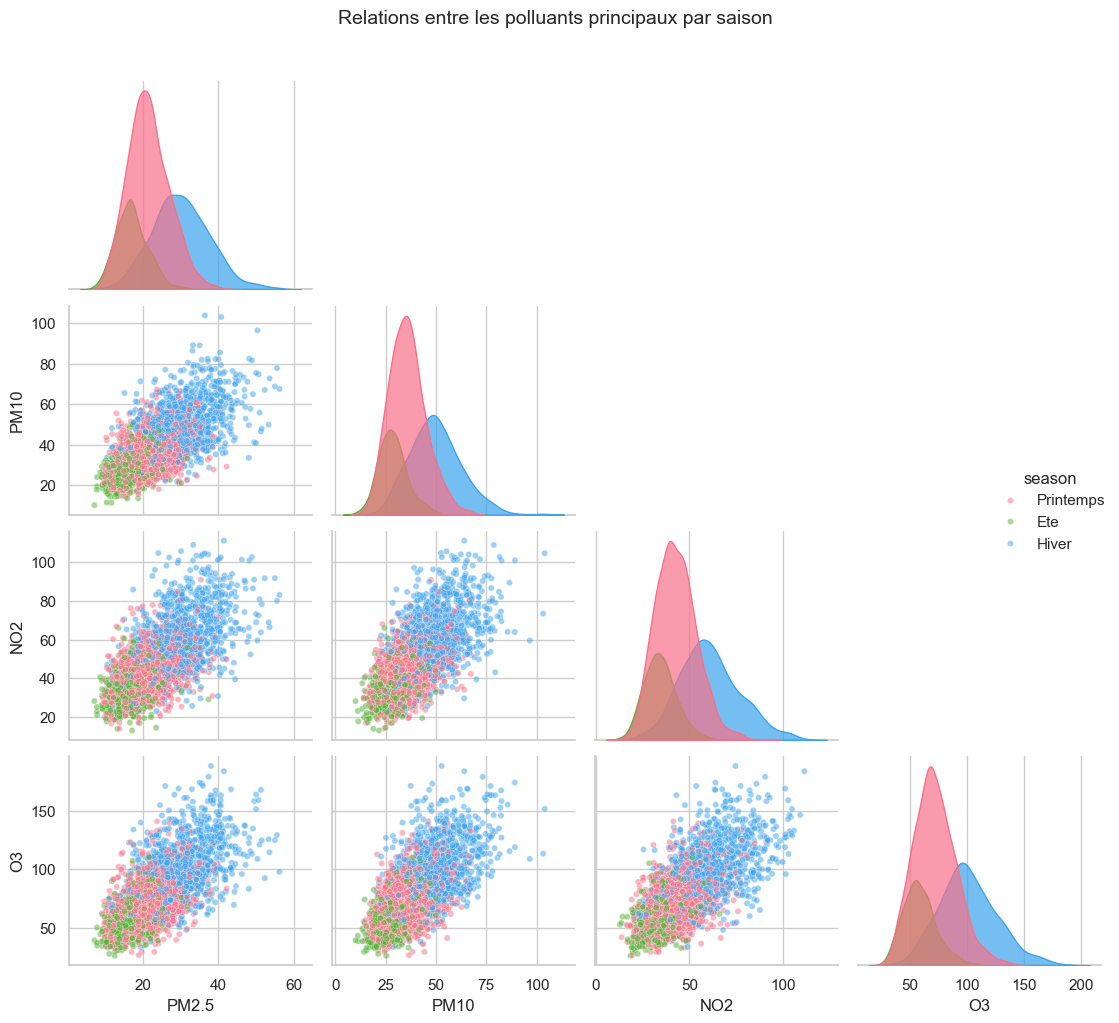

Figure sauvegardee: C:\Users\Administrateur\Desktop\spark-pandas-viz-lab\data\output\figures/06_pairplot_polluants.png


In [34]:
## Pairplot
g = sns.pairplot(
    df_sample[available_pollutants + ['season']],
    hue='season',
    palette='husl',
    diag_kind='kde',
    plot_kws={'alpha': 0.5, 's': 20},
    diag_kws={'alpha': 0.7},
    corner=True
)

g.fig.suptitle('Relations entre les polluants principaux par saison', y=1.02, fontsize=14)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/06_pairplot_polluants.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure sauvegardee: {FIGURES_DIR}/06_pairplot_polluants.png")

---

## 6.2 Violin plot des PM2.5 par saison

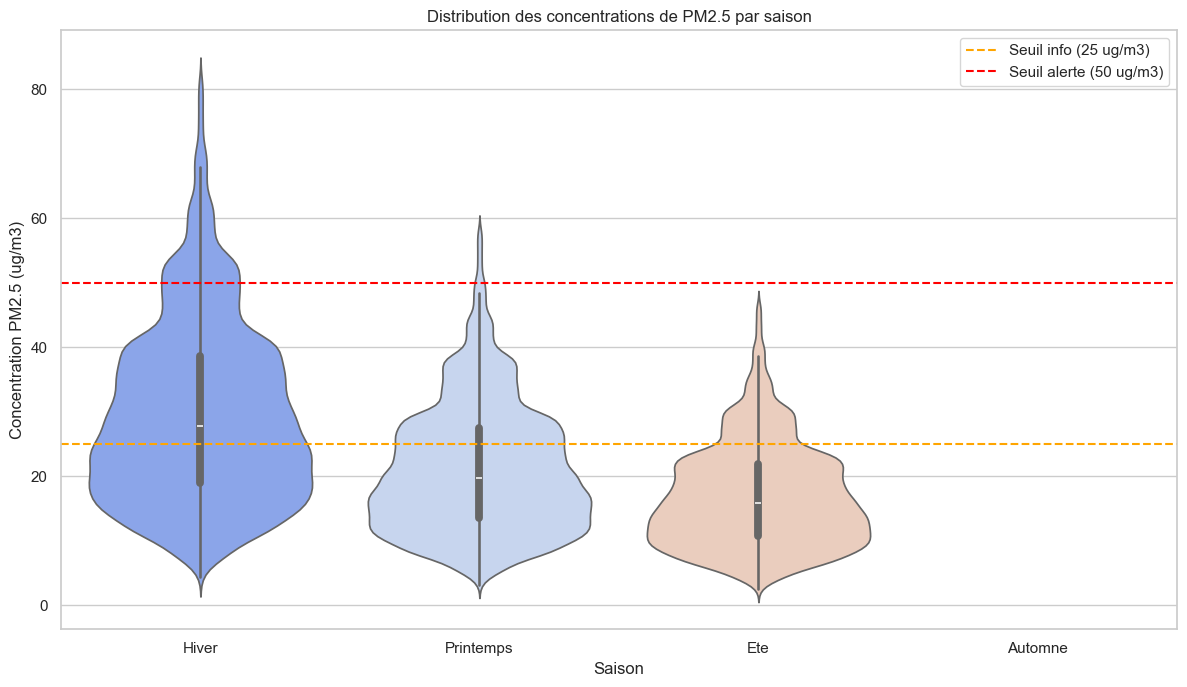

Figure sauvegardee: C:\Users\Administrateur\Desktop\spark-pandas-viz-lab\data\output\figures/07_violin_pm25_saison.png


In [35]:
## Filtrer PM2.5
df_pm25 = df[df['pollutant'] == 'PM2.5'].copy()

## Ordre des saisons
season_order = ['Hiver', 'Printemps', 'Ete', 'Automne']

## Figure
fig, ax = plt.subplots(figsize=(12, 7))

## Violin plot
sns.violinplot(
    data=df_pm25,
    x='season',
    y=value_col,
    order=season_order,
    palette='coolwarm',
    inner='box',
    ax=ax
)

## Seuils
ax.axhline(y=25, color='orange', linestyle='--', linewidth=1.5, label='Seuil info (25 ug/m3)')
ax.axhline(y=50, color='red', linestyle='--', linewidth=1.5, label='Seuil alerte (50 ug/m3)')

ax.set_xlabel('Saison')
ax.set_ylabel('Concentration PM2.5 (ug/m3)')
ax.set_title('Distribution des concentrations de PM2.5 par saison')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/07_violin_pm25_saison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure sauvegardee: {FIGURES_DIR}/07_violin_pm25_saison.png")

---

## 6.3 Heatmap de la matrice de corrélation avec annotations

In [36]:
## Preparer les donnees pour correlation
meteo_cols = ['temperature_c', 'humidity_pct', 'wind_speed_kmh', 'precipitation_mm']
available_meteo = [m for m in meteo_cols if m in df_pivot.columns]

## Ajouter meteo au pivot
df_meteo_unique = df[['datetime_hour', 'city'] + available_meteo].drop_duplicates()
df_corr = df_pivot.merge(df_meteo_unique, on=['datetime_hour', 'city'], how='left')

## Colonnes pour correlation
corr_cols = available_pollutants + available_meteo

## Renommer pour lisibilite
rename_map = {
    'temperature_c': 'Temperature',
    'humidity_pct': 'Humidite',
    'wind_speed_kmh': 'Vent',
    'precipitation_mm': 'Pluie'
}

df_corr_renamed = df_corr[corr_cols].rename(columns=rename_map)

## Matrice de correlation
correlation_matrix = df_corr_renamed.corr()

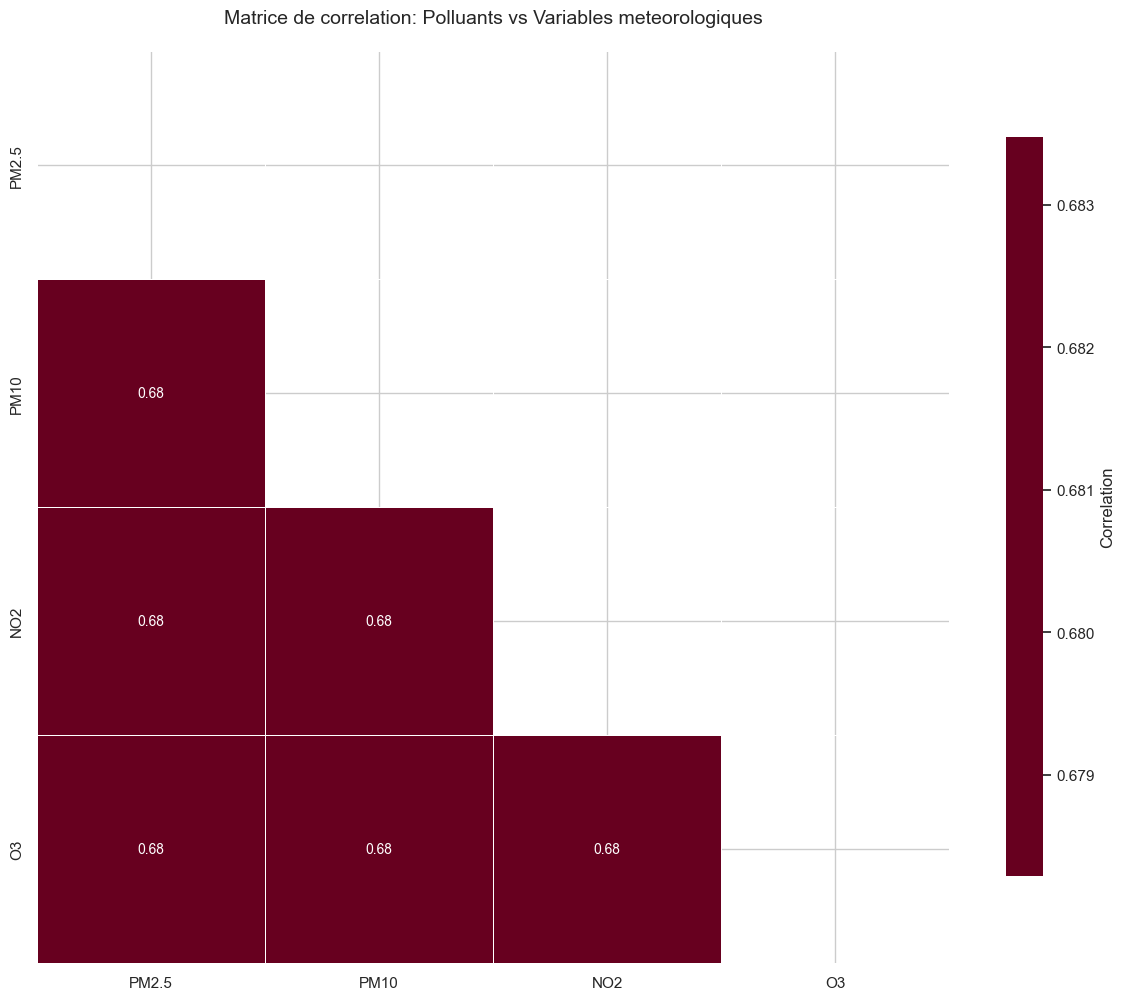

Figure sauvegardee: C:\Users\Administrateur\Desktop\spark-pandas-viz-lab\data\output\figures/08_heatmap_correlation.png


In [37]:
## Heatmap
fig, ax = plt.subplots(figsize=(12, 10))

## Masque pour triangle superieur
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

## Heatmap
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
    ax=ax,
    annot_kws={'size': 10}
)

ax.set_title('Matrice de correlation: Polluants vs Variables meteorologiques', fontsize=14, pad=20)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/08_heatmap_correlation.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure sauvegardee: {FIGURES_DIR}/08_heatmap_correlation.png")

---

## 6.4 FacetGrid: Evolution temporelle par ville

In [38]:
## Agreger par jour et ville pour PM2.5
df_pm25_daily = df[df['pollutant'] == 'PM2.5'].copy()
df_pm25_daily['date'] = pd.to_datetime(df_pm25_daily['date'])

daily_by_city = df_pm25_daily.groupby(['date', 'city'])[value_col].mean().reset_index()

## Top 6 villes par pollution moyenne
top_cities = daily_by_city.groupby('city')[value_col].mean().nlargest(6).index.tolist()
daily_top = daily_by_city[daily_by_city['city'].isin(top_cities)]

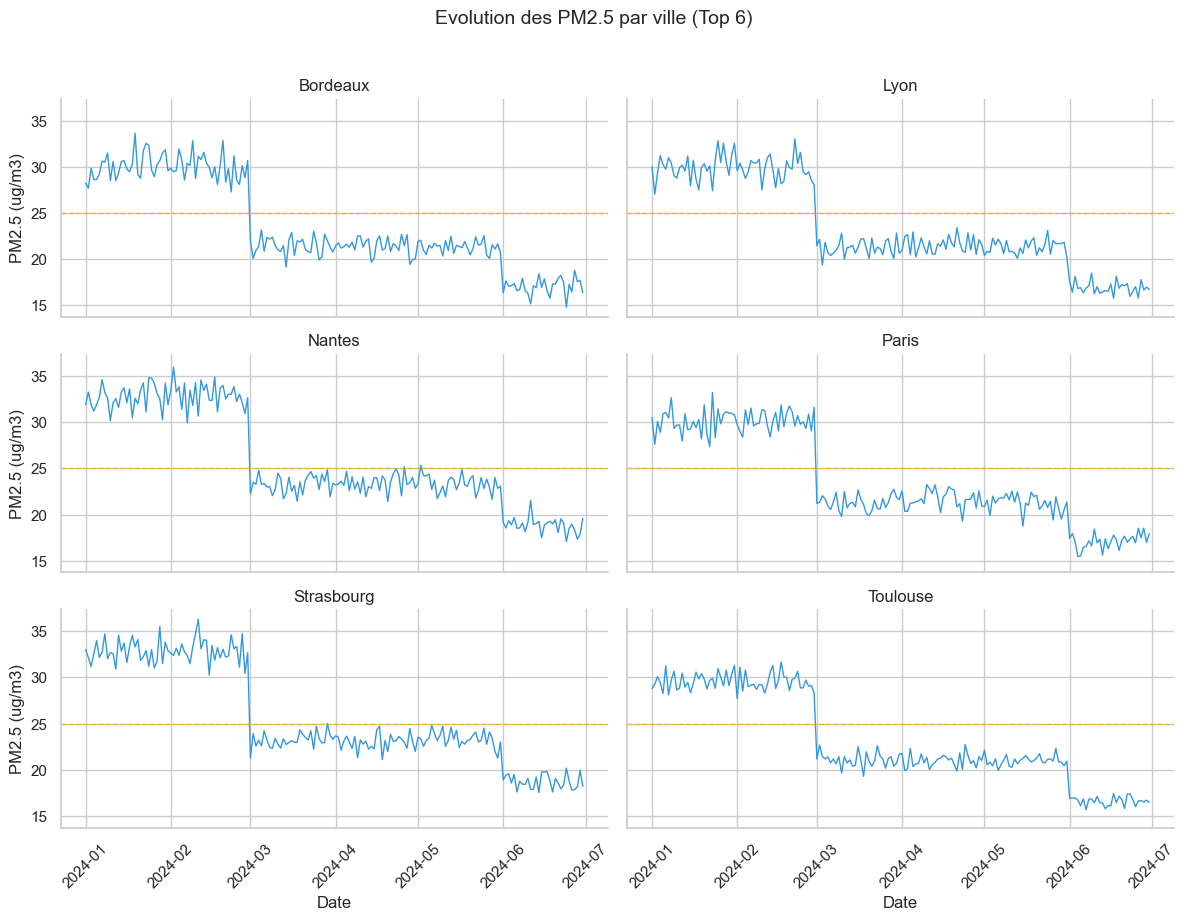

Figure sauvegardee: C:\Users\Administrateur\Desktop\spark-pandas-viz-lab\data\output\figures/09_facetgrid_villes.png


In [39]:
## FacetGrid
g = sns.FacetGrid(
    daily_top,
    col='city',
    col_wrap=2,
    height=3,
    aspect=2,
    sharey=True
)

g.map_dataframe(sns.lineplot, x='date', y=value_col, color='#3498DB', linewidth=1)

## Ajouter seuil
for ax in g.axes.flat:
    ax.axhline(y=25, color='orange', linestyle='--', linewidth=1, alpha=0.7)
    ax.tick_params(axis='x', rotation=45)

g.set_axis_labels('Date', 'PM2.5 (ug/m3)')
g.set_titles('{col_name}')
g.fig.suptitle('Evolution des PM2.5 par ville (Top 6)', y=1.02, fontsize=14)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/09_facetgrid_villes.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure sauvegardee: {FIGURES_DIR}/09_facetgrid_villes.png")

---

## 6.5 Jointplot: Relation humidite/PM2.5

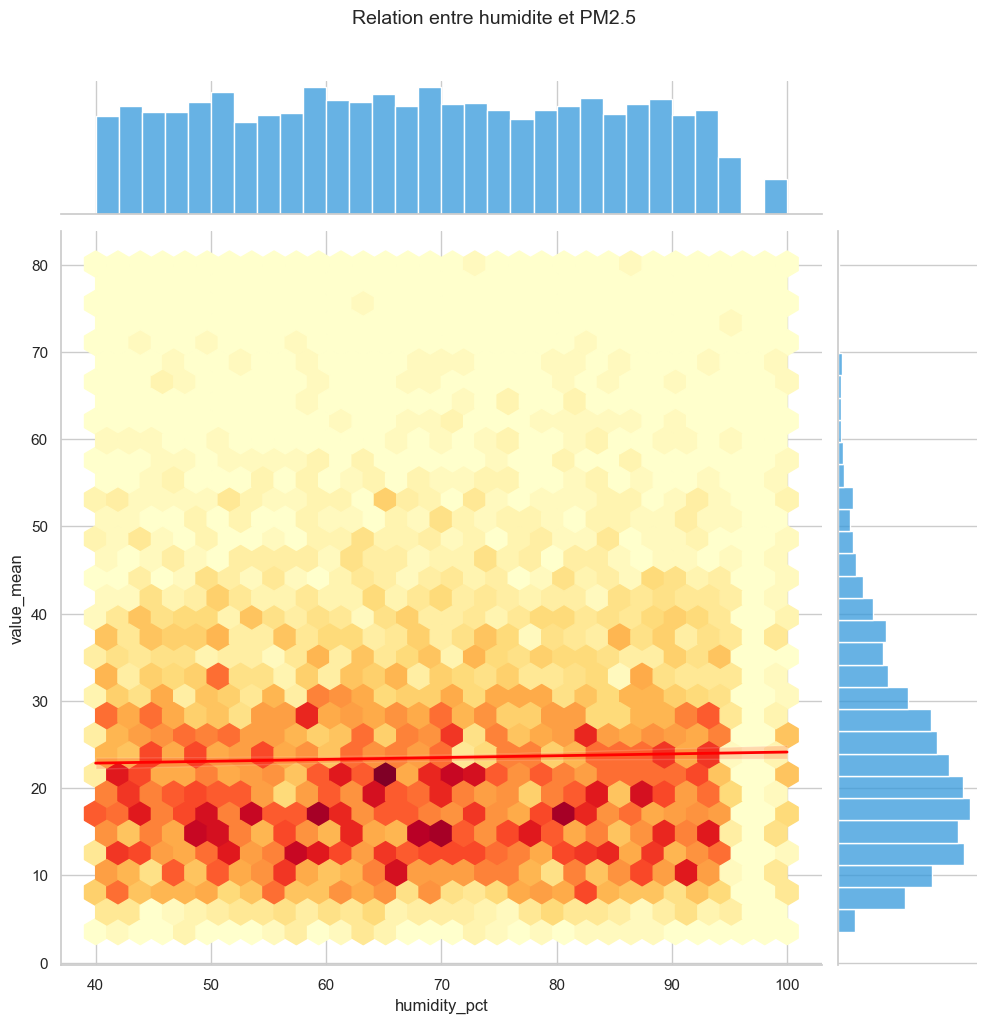

Figure sauvegardee: C:\Users\Administrateur\Desktop\spark-pandas-viz-lab\data\output\figures/10_jointplot_humidite_pm25.png


In [40]:
## Donnees PM2.5 avec humidite
df_joint = df[(df['pollutant'] == 'PM2.5') & (df['humidity_pct'].notna())].copy()

## Echantillonner
if len(df_joint) > 5000:
    df_joint_sample = df_joint.sample(5000, random_state=42)
else:
    df_joint_sample = df_joint

## Jointplot
g = sns.jointplot(
    data=df_joint_sample,
    x='humidity_pct',
    y=value_col,
    kind='hex',
    cmap='YlOrRd',
    marginal_kws={'color': '#3498DB', 'bins': 30},
    height=10
)

g.ax_joint.set_xlabel('Humidite (%)')
g.ax_joint.set_ylabel('Concentration PM2.5 (ug/m3)')
g.fig.suptitle('Relation entre humidite et PM2.5', y=1.02, fontsize=14)

## Ajouter regression
sns.regplot(
    data=df_joint_sample,
    x='humidity_pct',
    y=value_col,
    scatter=False,
    ax=g.ax_joint,
    color='red',
    line_kws={'linewidth': 2}
)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/10_jointplot_humidite_pm25.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Figure sauvegardee: {FIGURES_DIR}/10_jointplot_humidite_pm25.png")

---

## 6.6 Catplot: Comparaison polluants par type de station

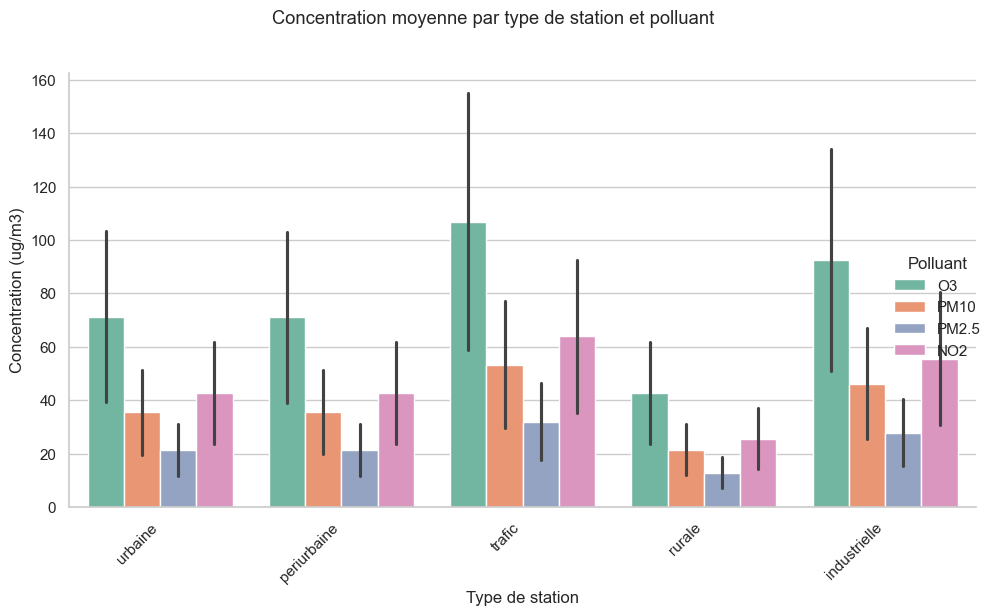

Figure sauvegardee: C:\Users\Administrateur\Desktop\spark-pandas-viz-lab\data\output\figures/11_catplot_station_type.png


In [41]:
## Verifier si station_type existe
if 'station_type' in df.columns:
    # Moyennes par type de station et polluant
    df_station_type = df[df['pollutant'].isin(['PM2.5', 'PM10', 'NO2', 'O3'])].copy()
    
    # Catplot
    g = sns.catplot(
        data=df_station_type,
        x='station_type',
        y=value_col,
        hue='pollutant',
        kind='bar',
        height=6,
        aspect=1.5,
        palette='Set2',
        errorbar='sd'
    )
    
    g.set_axis_labels('Type de station', 'Concentration (ug/m3)')
    g.legend.set_title('Polluant')
    g.fig.suptitle('Concentration moyenne par type de station et polluant', y=1.02)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{FIGURES_DIR}/11_catplot_station_type.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Figure sauvegardee: {FIGURES_DIR}/11_catplot_station_type.png")
else:
    print("Colonne 'station_type' non disponible dans les donnees.")

---

## 6.7 Resume des figures Seaborn

In [42]:
## Lister les figures Seaborn
figures = [f for f in os.listdir(FIGURES_DIR) if f.startswith(('06_', '07_', '08_', '09_', '10_', '11_'))]

print("Figures Seaborn generees:")
for f in sorted(figures):
    filepath = os.path.join(FIGURES_DIR, f)
    size = os.path.getsize(filepath) / 1024
    print(f"  {f} ({size:.1f} KB)")

Figures Seaborn generees:
  06_pairplot_polluants.png (1978.5 KB)
  07_violin_pm25_saison.png (242.8 KB)
  08_heatmap_correlation.png (133.9 KB)
  09_facetgrid_villes.png (529.1 KB)
  10_jointplot_humidite_pm25.png (413.5 KB)
  11_catplot_station_type.png (146.3 KB)
